In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scripts import markov_chain_2 as mac

from scripts import shapley as shp

from scripts import viz as viz


In [2]:
df = pd.read_csv(r"C:\Users\Krina\markov_chain_portfolio\data\ga_2.csv")


C:\Users\Krina\AppData\Local\Temp\ipykernel_2380\3194758757.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\Krina\markov_chain_portfolio\data\ga_2.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203317 entries, 0 to 203316
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       203317 non-null  object
 1   session_time  203317 non-null  object
 2   channel       203317 non-null  object
 3   converted     203317 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 4.8+ MB


In [4]:
df.head()

,user_id,session_time,channel,converted
0,7748782825261851002,2017-05-05 18:29:57 UTC,(Other),False
1,7748782825261851002,2017-05-05 18:19:37 UTC,(Other),False
2,9813549014448545779,2017-05-17 18:57:25 UTC,(Other),False
3,0964784969815496083,2017-05-19 16:48:36 UTC,(Other),False
4,5302771102738976470,2017-07-22 21:48:45 UTC,(Other),False


In [5]:
df.nunique()

user_id         165542
session_time    199943
channel              8
converted            2
dtype: int64

In [6]:
df["channel"].nunique()

8

In [7]:
df["channel"].value_counts()

channel
Organic Search    108029
Direct             38758
Referral           28812
Social             14502
Paid Search         7242
Affiliates          4470
Display             1498
(Other)                6
Name: count, dtype: int64

In [8]:
df = df[df['channel'] != '(Other)']

In [9]:
df["channel"].value_counts()

channel
Organic Search    108029
Direct             38758
Referral           28812
Social             14502
Paid Search         7242
Affiliates          4470
Display             1498
Name: count, dtype: int64

In [10]:
df.columns.tolist()


['user_id', 'session_time', 'channel', 'converted']

In [11]:
df_paths = mac.create_user_journeys(df)

In [12]:
df_paths.head()

,user_id,session_time,channel_list,converted,Timestamp,result,user_journey
0,62349695125717,[2017-06-07 06:34:00 UTC],[referral],[False],[2017-06-07 06:34:00+00:00],dropped,"[start, referral, dropped]"
1,170187170673177,"[2017-06-08 18:28:30 UTC, 2017-06-08 21:18:32 ...","[referral, referral, referral, referral, refer...","[False, False, False, False, False, False, Fal...","[2017-06-08 18:28:30+00:00, 2017-06-08 21:18:3...",dropped,"[start, referral, referral, referral, referral..."
2,197671390269035,[2017-05-03 00:54:30 UTC],[social],[False],[2017-05-03 00:54:30+00:00],dropped,"[start, social, dropped]"
3,277260039178149,[2017-07-15 08:06:37 UTC],[social],[False],[2017-07-15 08:06:37+00:00],dropped,"[start, social, dropped]"
4,293088006393965,"[2017-07-16 23:10:40 UTC, 2017-07-17 08:56:29 ...","[social, social]","[False, False]","[2017-07-16 23:10:40+00:00, 2017-07-17 08:56:2...",dropped,"[start, social, social, dropped]"


In [13]:
df_paths["result"].value_counts()

result
dropped       162684
conversion      2855
Name: count, dtype: int64

In [14]:
count_df, prob_df = mac.create_transition_matrix(df, df_paths)

In [15]:
prob_df.loc['start']

start             0.0000
affiliates        0.0209
direct            0.1889
display           0.0045
organic search    0.5600
paid search       0.0334
referral          0.1128
social            0.0796
conversion        0.0000
dropped           0.0000
Name: start, dtype: float64

## Transition Matrix

The transition matrix shows the probability of moving from one channel to another in the user journey.

In [16]:
count_df, prob_df =  mac.create_transition_matrix(df, df_paths)
print("Count Matrix:\n", count_df)
print("\nProbability Matrix:\n", prob_df)

Count Matrix:
                 start  affiliates  direct  display  organic search  \
start               0        3462   31267      744           92697   
affiliates          0         771       0        2              80   
direct              0          67    7482       77             654   
display             0           1       0      461              72   
organic search      0         169       9      214           14141   
paid search         0           0       0        0             174   
referral            0           0       0        0             182   
social              0           0       0        0              29   
conversion          0           0       0        0               0   
dropped             0           0       0        0               0   

                paid search  referral  social  conversion  dropped  
start                  5523     18675   13171           0        0  
affiliates                0         0       0           5     3612  
direct 

## Baseline Conversion Probability

In [17]:
# Baseline conversion probability: start -> conversion
baseline_conv = prob_df.loc['start', 'conversion']
baseline_conv

np.float64(0.0)

In [18]:
print(baseline_conv)

0.0


## Q Matrix

The Q matrix contains the probabilities of moving from one channel to another, excluding absorption states.

In [19]:
absorbing_states = ['conversion','dropped']
q_matrix = mac.extract_q_matrix(prob_df, absorbing_states)
print("Q matrix transient to transient")
print(q_matrix)

Q matrix transient to transient
(                start  affiliates  direct  display  organic search  \
start             0.0      0.0209  0.1889   0.0045          0.5600   
affiliates        0.0      0.1725  0.0000   0.0004          0.0179   
direct            0.0      0.0017  0.1930   0.0020          0.0169   
display           0.0      0.0007  0.0000   0.3077          0.0481   
organic search    0.0      0.0016  0.0001   0.0020          0.1309   
paid search       0.0      0.0000  0.0000   0.0000          0.0240   
referral          0.0      0.0000  0.0000   0.0000          0.0063   
social            0.0      0.0000  0.0000   0.0000          0.0020   

                paid search  referral  social  
start                0.0334    0.1128  0.0796  
affiliates           0.0000    0.0000  0.0000  
direct               0.0000    0.0000  0.0000  
display              0.0000    0.0000  0.0000  
organic search       0.0011    0.0023  0.0004  
paid search          0.2120    0.0061  0.0015  


In [20]:
Q, T = mac.extract_q_matrix(prob_df, absorbing_states)

In [21]:
print("Q shape:", Q.shape)

Q shape: (8, 8)


## Sanity Check - Row sum for Q

In [22]:
Q_row_sums = Q.sum(axis=1)
Q_row_sums


start             1.0001
affiliates        0.1908
direct            0.2136
display           0.3565
organic search    0.1384
paid search       0.2436
referral          0.3493
social            0.0918
dtype: float64

start row is 1 , and other rows are less than 1, so missing probability will go in absorbing states (conversion, dropped) via R, so for further sanity check row sum of Q and R must be 1

In [23]:
R, _ = mac.extract_r_matrix(prob_df, absorbing_states)

In [24]:
print("R shape:", R.shape)

R shape: (8, 2)


In [25]:
print("R matrix transient to absorption")
print(R)

R matrix transient to absorption
                conversion  dropped
start               0.0000   0.0000
affiliates          0.0011   0.8081
direct              0.0130   0.7733
display             0.0200   0.6235
organic search      0.0076   0.8541
paid search         0.0191   0.7374
referral            0.0459   0.6048
social              0.0024   0.9058


In [26]:
R_row_sums = R.sum(axis=1)

In [27]:
R_row_sums

start             0.0000
affiliates        0.8092
direct            0.7863
display           0.6435
organic search    0.8617
paid search       0.7565
referral          0.6507
social            0.9082
dtype: float64

In [28]:
check = (Q_row_sums + R_row_sums).round(4)

In [29]:
check

start             1.0001
affiliates        1.0000
direct            0.9999
display           1.0000
organic search    1.0001
paid search       1.0001
referral          1.0000
social            1.0000
dtype: float64

In [30]:
eigenvalues = np.linalg.eigvals(Q)
print(eigenvalues)
print("All eigenvalues < 1?", np.all(np.abs(eigenvalues) < 1))

[0.         0.0822011  0.12930966 0.1731392  0.19302779 0.21225154
 0.33872349 0.30824723]
All eigenvalues < 1? True


In [31]:
N_matrix = mac.compute_fundamental_matrix(Q)
print("Fundamental Matrix (N):")
print(N_matrix)

Fundamental Matrix (N):
                start  affiliates        direct   display  organic search  \
start             1.0    0.027007  2.341577e-01  0.009078        0.652628   
affiliates        0.0    1.208508  3.089811e-06  0.000770        0.024935   
direct            0.0    0.002596  1.239160e+00  0.003652        0.024353   
display           0.0    0.001377  9.911982e-06  1.444692        0.079990   
organic search    0.0    0.002228  1.426175e-04  0.003327        1.150923   
paid search       0.0    0.000068  4.354903e-06  0.000102        0.035144   
referral          0.0    0.000021  1.369615e-06  0.000032        0.011053   
social            0.0    0.000005  3.259120e-07  0.000008        0.002630   

                paid search  referral    social  
start              0.043762  0.174029  0.087663  
affiliates         0.000035  0.000087  0.000011  
direct             0.000034  0.000085  0.000011  
display            0.000112  0.000279  0.000036  
organic search     0.001615  0.0

## Sanity Check

In [32]:
np.diag(N_matrix)


array([1.        , 1.20850808, 1.23916039, 1.4446924 , 1.1509233 ,
       1.26911038, 1.51182814, 1.08971863])

In [33]:
N_matrix.sum(axis=1).sort_values(ascending=False)

start             2.228325
referral          1.530788
display           1.526496
paid search       1.318402
direct            1.269891
affiliates        1.234350
organic search    1.162775
social            1.104448
dtype: float64

In [34]:
N_matrix.replace([np.inf, -np.inf], np.nan).isna().sum().sum()


np.int64(0)

In [35]:
B = N_matrix @ R
start_idx = N_matrix.index.tolist().index('start')
baseline_conv = B['conversion'].iloc[start_idx]
baseline_conv

np.float64(0.017249460319639427)

Starting from “start”, what is the probability a user will eventually convert before dropping?

So:

baseline conversion probability = 0.017

  


Earlier:

2,855 conversions

165,539 total journeys

empirical conversion rate ≈ 1.72%

 Markov baseline = 1.7


so:

transition matrix is correct
Q/R extraction is correct
Fundamental matrix  is correct
Absorption computation is correct

In [36]:
ranked_channels, N_matrix = mac.rank_channels_by_expected_visits(Q, mac.compute_fundamental_matrix)

Ranked Channels by Expected Visits Before Absorption:
organic search    1.981656
referral          1.712579
direct            1.473480
display           1.461660
paid search       1.319252
affiliates        1.241811
social            1.185038
start             1.000000
dtype: float64


This ranking is based on the Fundamental Matrix (N) and answers:

“If a user reaches this channel, how many more times will they interact with any channel before converting or dropping?”

This is a behavioral engagement ranking, not an attribution score.

Organic Search is highest → users entering via Organic Search tend to stay engaged and continue exploring multiple touchpoints.

Referral + Display → long exploration → possibly top-of-funnel awareness channels.

Social is near the bottom → quick exit or quick decision behavior.


 This does NOT tell us which channels drive conversions.

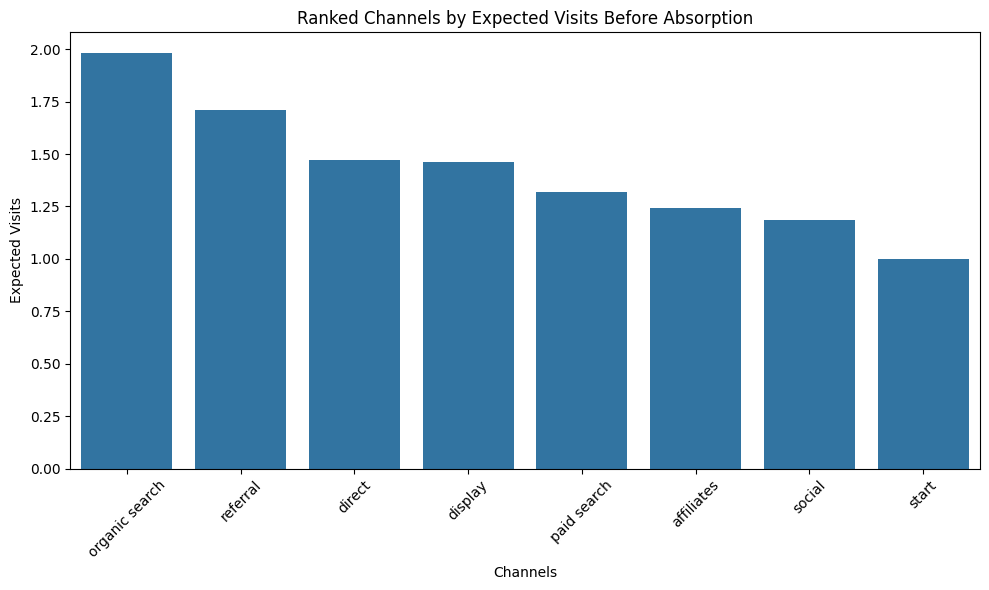

In [37]:
viz.plot_ranked_channels(ranked_channels)

In [38]:
transition_table = mac.build_transition_counts(df_paths)

In [39]:
transition_table.head(20)

,source,target,count
0,start,organic search,92697
1,organic search,dropped,92264
2,start,direct,31267
3,direct,dropped,29973
4,start,referral,18675
5,referral,dropped,17425
6,organic search,organic search,14141
7,start,social,13171
8,social,dropped,13136
9,referral,referral,9754


## Export CSV

transition_table.to_csv("transition_counts.csv", index=False)


Highlight Top Contributors

In [40]:
transition_table[
    transition_table["count"] > transition_table["count"].quantile(0.90)
]


,source,target,count
0,start,organic search,92697
1,organic search,dropped,92264
2,start,direct,31267
3,direct,dropped,29973
4,start,referral,18675


In [41]:
fig = viz.generate_sankey_pro(df_paths, min_threshold=0.005)

## Matrix B

In [42]:
b_matrix = mac.compute_absorption_probabilities(N_matrix, R)

Absorption probability matrix (B = N × R):
                conversion  dropped
start               0.0172   0.9829
affiliates          0.0015   0.9985
direct              0.0164   0.9835
display             0.0295   0.9705
organic search      0.0090   0.9911
paid search         0.0251   0.9751
referral            0.0695   0.9305
social              0.0031   0.9969


In [43]:
conversion_probs = mac.get_conversion_probabilities(b_matrix)

Channel Conversion Probabilities (→ conversion):
referral          6.95%
display           2.95%
paid search       2.51%
start             1.72%
direct            1.64%
organic search    0.90%
social            0.31%
affiliates        0.15%
Name: conversion, dtype: object


In [44]:
print(conversion_probs)

referral          6.95%
display           2.95%
paid search       2.51%
start             1.72%
direct            1.64%
organic search    0.90%
social            0.31%
affiliates        0.15%
Name: conversion, dtype: object


In [45]:
baseline_conversion = (N_matrix @ R).loc['start', 'conversion']
baseline_conversion

np.float64(0.017249460319639427)

In [46]:
effects = mac.removal_effects(prob_df, absorbing_states, N_matrix, R)
print("Removal Effects:\n", effects.astype(str) + " pp")

Removal Effects:
 referral           0.8 pp
organic search    0.51 pp
direct            0.31 pp
paid search       0.09 pp
social            0.03 pp
display           0.02 pp
affiliates         0.0 pp
dtype: object


## Sanity Check

In [47]:
effects_numeric = effects.astype(float)
print("Total Removal Effect:", effects_numeric.sum(), "pp")

Total Removal Effect: 1.7600000000000002 pp


In [48]:
# count how many channels per user
df_paths['num_channels'] = df_paths['channel_list'].apply(len)

In [49]:
multi_touch_count = (df_paths['num_channels'] >= 2).sum()
total_users = len(df_paths)

In [50]:
mts = multi_touch_count / total_users
print("Multi-Touch Score (fraction of users with 2+ channels):", round(mts, 4))

Multi-Touch Score (fraction of users with 2+ channels): 0.1288


In [53]:
THRESHOLD = 0.25   # heuristic threshold for multi-touch fraction

if mts < THRESHOLD:
    print("Multi-Touch Score < {:.0%} → Markov not reliable. Running Shapley fallback…".format(THRESHOLD))
    

    df_shap = shp.preprocess_for_shapley(df_paths)
    shapley_results = shp.compute_shapley(df_shap)

    print("\nShapley Attribution Results (% share of conversions):")
    display(shapley_results)

    print("Sum of Shapley shares:", shapley_results.sum(), "%")
else:
    print("Multi-Touch Score ≥ {:.0%} → Markov considered reliable. Skipping Shapley.".format(THRESHOLD))

Multi-Touch Score < 25% → Markov not reliable. Running Shapley fallback…

Shapley Attribution Results (% share of conversions):


organic search    56.11
direct            18.65
referral          11.29
social             7.96
paid search        3.33
affiliates         2.14
display            0.52
dtype: float64

Sum of Shapley shares: 99.99999999999997 %
